In [95]:
import pandas as pd
import numpy as np
import os
import sys
!pip -qq install psutil
import psutil
from time import time, sleep
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import resource
from glob import glob
from IPython.display import clear_output
from sklearn.covariance import EmpiricalCovariance as EC
from NSGPy.NumPy import LLS
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from GPy.models import GPRegression as GPR
from GPy.kern import Matern32

In [96]:
a = np.random.rand(10,50)
m = EC()
m.fit(a)

EmpiricalCovariance()

In [97]:
a = np.random.rand(5,5)
print(np.linalg.inv(a))
print(np.linalg.inv(a[:3,:3]))
a = [8,9,10,11]
a.remove(11)
a

[[-1.23396867  1.01225245  4.73033096  0.62876698 -7.61979096]
 [-1.82787631  1.7272771  -1.8550197   2.21473093 -0.10703669]
 [-1.40494466  0.43640003 -6.74468206  0.57464248 12.65083928]
 [ 2.42470312 -2.52416289  5.65529165 -0.82485827 -6.52748194]
 [ 2.61629615 -0.22137161  1.62508706 -1.64136668 -4.08777221]]
[[-2.51091129  5.88237082 -4.58323636]
 [ 0.30721679  4.46157854 -5.74433351]
 [ 2.2948811  -5.69319155  5.9605111 ]]


[8, 9, 10]

## Data preperation

In [98]:
main_path = '~/Nonstat-exps/gp_extra/'
df = pd.read_csv(main_path+'data/beijing_AQI.csv').rename(columns={'PM25_Concentration':'PM25','longitude':'long','latitude':'lat'})
df = df.set_index('time').sort_values(['time', 'station_id'])
print('unique timestamps are',len(df.index.unique()))
useful_ts = []
for ts in df.index.unique():
  if(len(df.loc[ts])==36):
    useful_ts.append(ts)
df = df.loc[useful_ts]
df['PM25'] = df['PM25'].astype(float)
print('unique timestamps after removing missing entry time-stamps are',len(useful_ts))
df.columns

n_ts = len(useful_ts)
K = 3 #  Number of folds
n_val = 6 # Number of validation stations

splitter = KFold(K, shuffle=True, random_state=0)
stations = np.sort(df['station_id'].unique())
folds={i:{'train':None,'val':None,'test':None} for i in range(K)}
for i, (train_val, test) in enumerate(splitter.split(stations)):
    folds[i]['train'] = stations[train_val[:-n_val]]
    folds[i]['val'] = stations[train_val[-n_val:]]
    folds[i]['test'] = stations[test]
    
###########################
# Data preperation
###########################
data = {i:{'train_Xy':None,'val_Xy':None,'test_Xy':None} for i in range(K)}
for fold in range(K):
    for part in ['train','val','test']:
        data[fold][part+'_Xy'] = (df[df.station_id.isin(folds[fold][part])][['long', 'lat']], 
                                  df[df.station_id.isin(folds[fold][part])][['PM25']])

unique timestamps are 7460
unique timestamps after removing missing entry time-stamps are 2132


In [99]:
data[0]['train_Xy'][1].values.shape

(38376, 1)

In [100]:
a = np.random.rand(6,1)
b = a.reshape(3,2,order='F')
a, b[:,0]

(array([[0.95214463],
        [0.71051118],
        [0.89213473],
        [0.47175788],
        [0.62364751],
        [0.36969825]]),
 array([0.95214463, 0.71051118, 0.89213473]))

## Predicting average of train

In [101]:
n_ts = 24
preds = []
tests = []
n_fold_rmse = []
for fold in range(K):
    f_preds = []
    f_tests = []
    fold_rmse = []
    for ts_n in range(n_ts):
        ts = df.index.unique()[ts_n]
        f_tests.append(data[fold]['test_Xy'][1].loc[ts].values)
        f_preds.append(np.array([np.mean(data[fold]['train_Xy'][1].loc[ts].values)]*\
                                data[fold]['test_Xy'][1].loc[ts].values.shape[0]).reshape(-1,1))
        preds.append(f_preds[-1])
        tests.append(data[fold]['test_Xy'][1].loc[ts].values)
        fold_rmse.append(mean_squared_error(f_tests[-1], f_preds[-1], squared=False))
        n_fold_rmse.append(mean_squared_error(f_tests[-1], f_preds[-1], squared=False))
    print('mean fold rmse (mean)', np.mean(fold_rmse))
    print('mean fold rmse (ind)', mean_squared_error(np.concatenate(f_tests), np.concatenate(f_preds), squared=False))
print('mean overall rmse (mean)', np.mean(n_fold_rmse))
print('mean overall rmse (ind)', mean_squared_error(np.concatenate(tests), np.concatenate(preds), squared=False))

mean fold rmse (mean) 24.70773388766678
mean fold rmse (ind) 27.593989213970872
mean fold rmse (mean) 21.62179791334053
mean fold rmse (ind) 24.67904573426431
mean fold rmse (mean) 25.504236190521677
mean fold rmse (ind) 27.428371924336904
mean overall rmse (mean) 23.94458933050966
mean overall rmse (ind) 26.60074638999442


## df to save all results

In [102]:
n_time_i = np.array(df.index.unique().tolist()*3).reshape(1,-1)
n_time_id = np.array(list(range(len(df.index.unique())))*3).reshape(1,-1)
n_fold_i = np.concatenate([np.ones(n_time_i.shape[1]//3)*0, 
                           np.ones(n_time_i.shape[1]//3)*1, 
                           np.ones(n_time_i.shape[1]//3)*2]).reshape(1,-1).astype(int)
mult_i = np.concatenate([n_time_id, n_time_i, n_fold_i], axis=0)
master_df = pd.DataFrame(index=pd.MultiIndex.from_arrays(mult_i))

## K fold GP-LLS - matern

In [103]:
path = 'results/raw_gp_lls_self_greedy/'
kernel = 'matern'
n_ts = 24

In [105]:
# Check if works
# !python scripts/process_gp_lls_self_greedy.py 0 1 matern 24

### Training

In [108]:
init = time()
jobs = []
for fold in range(K):
    for ts in range(n_ts):
        jobs.append('python scripts/process_gp_lls_self_greedy.py {0} {1} {2} {3}'.format(ts, fold, kernel, n_ts))

print('starting',len(jobs),'jobs on',psutil.cpu_count(),'CPUs')
sleep(1)
n_splits = len(jobs)//32
for b_id, batch in enumerate(np.array_split(jobs, n_splits)):
    print('start',b_id+1,'of',n_splits)
    print('length of batch=',len(batch))
    os.system(' | '.join(batch))
    clear_output(wait=True)
    print('end',b_id+1,'of',n_splits)
print((time()-init)/60, 'all fold complete')

end 2 of 2
6.22829331556956 all fold complete


### RMSE calculation

In [109]:
path = 'results/raw_gp_lls_self_greedy/'+kernel+'/'
name = 'lls_matern'
master_df[name] = None
preds = []
tests = []
mean_rmse_per_fold = []
success = []
n_fold_rmse = []
for fold in folds:
    hyp = []
    fold_rmse = []
    tmp_preds_y = []
    tmp_models = []
    tmp_tests_y = []
    tmp_tests_x = []
    tmp_train_Xy = []
    for ts_n, ts in enumerate(df.index.unique()[:n_ts]):
        try:
            tmp = pd.read_pickle(path+'ts_'+str(ts)+'_fold_'+str(fold))
            hyp.append(tmp['best_hyperpara']['N'])
            preds.append(tmp['pred_y'].squeeze())
            tests.append(tmp['test_y'].squeeze())
            tmp_models.append(tmp['best_model'])
            tmp_train_Xy.append(tmp['train_Xy'])
            tmp_tests_x.append(tmp['test_Xy'][0].squeeze())
            tmp_preds_y.append(tmp['pred_y'].squeeze())
            tmp_tests_y.append(tmp['test_y'].squeeze())
            success.append(path+'ts_'+str(ts)+'_fold_'+str(fold))
            fold_rmse.append(mean_squared_error(tmp_tests_y[-1], tmp_preds_y[-1], squared=False))
            master_df.loc[(str(ts_n), str(ts), str(fold)),name] = mean_squared_error(tmp_tests_y[-1], tmp_preds_y[-1], squared=False)
            master_df.loc[(str(ts_n), str(ts), str(fold)),name+'_model'] = tmp['best_model']
        except:
            pass
    print('Fold',fold,'mean_rmse',np.mean(fold_rmse))
    mean_rmse_per_fold.append(np.mean(fold_rmse))
    print("Fold",fold,'individual_rmse',mean_squared_error(np.array(tmp_tests_y).flatten(), np.array(tmp_preds_y).flatten(), squared=False))
print("Overall RMSE (individual)", mean_squared_error(np.array(tests).flatten(), np.array(preds).flatten(), squared=False))
print("Overall RMSE (mean of folds)", np.mean(mean_rmse_per_fold))
pd.Series(hyp).value_counts(), len(tests), 24*3

Fold 0 mean_rmse 26.120793661254055
Fold 0 individual_rmse 29.337392375331813
Fold 1 mean_rmse 19.411562439376997
Fold 1 individual_rmse 21.888845198881267
Fold 2 mean_rmse 24.173595246802066
Fold 2 individual_rmse 26.649335065566312
Overall RMSE (individual) 26.14058909666209
Overall RMSE (mean of folds) 23.23531711581104


(4    7
 9    5
 6    3
 5    3
 3    3
 7    2
 8    1
 dtype: int64,
 72,
 72)

## Manual check (Misc.)

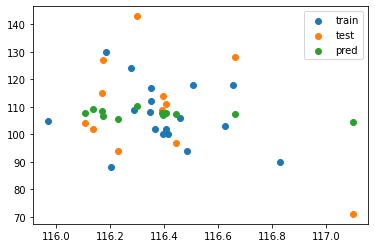

In [110]:
import matplotlib.pyplot as plt
N = 0
dim = 0
plt.plot()
plt.scatter(tmp_train_Xy[N][0][:,dim], tmp_train_Xy[N][1],label='train')
plt.scatter(tmp_tests_x[N][:,dim], tmp_tests_y[N],label='test')
plt.scatter(tmp_tests_x[N][:,dim], tmp_preds_y[N],label='pred')
plt.legend();

In [111]:
# pd.to_pickle(success, 'results/sync.pickle')

## K fold GP-LLS - rbf

In [112]:
path = 'results/raw_gp_lls_self_greedy/'
kernel = 'rbf'
n_ts = 24

### Training

In [113]:
init = time()
jobs = []
for fold in range(K):
    for ts in range(n_ts):
        jobs.append('python scripts/process_gp_lls_self_greedy.py {0} {1} {2} {3}'.format(ts, fold, kernel, n_ts))

print('starting',len(jobs),'jobs on',psutil.cpu_count(),'CPUs')
sleep(1)
n_splits = len(jobs)//64+1
for b_id, batch in enumerate(np.array_split(jobs, n_splits)):
    print('start',b_id+1,'of',n_splits)
    print('length of batch=',len(batch))
    os.system(' | '.join(batch))
    clear_output(wait=True)
    print('end',b_id+1,'of',n_splits)
print((time()-init)/60, 'minutes. all fold complete')

end 2 of 2
4.880542318026225 minutes. all fold complete


### RMSE calculation

In [114]:
path = 'results/raw_gp_lls_self_greedy/'+kernel+'/'
name = 'lls_rbf'
master_df[name] = None
preds = []
tests = []
mean_rmse_per_fold = []
success = []
n_fold_rmse = []
for fold in folds:
    hyp = []
    fold_rmse = []
    tmp_preds_y = []
    tmp_models = []
    tmp_tests_y = []
    tmp_tests_x = []
    tmp_train_Xy = []
    for ts_n, ts in enumerate(df.index.unique()[:n_ts]):
        try:
            tmp = pd.read_pickle(path+'ts_'+str(ts)+'_fold_'+str(fold))
            hyp.append(tmp['best_hyperpara']['N'])
            preds.append(tmp['pred_y'].squeeze())
            tests.append(tmp['test_y'].squeeze())
            tmp_models.append(tmp['best_model'])
            tmp_train_Xy.append(tmp['train_Xy'])
            tmp_tests_x.append(tmp['test_Xy'][0].squeeze())
            tmp_preds_y.append(tmp['pred_y'].squeeze())
            tmp_tests_y.append(tmp['test_y'].squeeze())
            success.append(path+'ts_'+str(ts)+'_fold_'+str(fold))
            fold_rmse.append(mean_squared_error(tmp_tests_y[-1], tmp_preds_y[-1], squared=False))
            master_df.loc[(str(ts_n), str(ts), str(fold)),name] = mean_squared_error(tmp_tests_y[-1], tmp_preds_y[-1], squared=False)
        except:
            pass
    print('Fold',fold,'mean_rmse',np.mean(fold_rmse))
    mean_rmse_per_fold.append(np.mean(fold_rmse))
    print("Fold",fold,'individual_rmse',mean_squared_error(np.array(tmp_tests_y).flatten(), np.array(tmp_preds_y).flatten(), squared=False))
print("Overall RMSE (individual)", mean_squared_error(np.array(tests).flatten(), np.array(preds).flatten(), squared=False))
print("Overall RMSE (mean of folds)", np.mean(mean_rmse_per_fold))
pd.Series(hyp).value_counts()

Fold 0 mean_rmse 27.570912064172024
Fold 0 individual_rmse 31.583389524936038
Fold 1 mean_rmse 21.267964375031763
Fold 1 individual_rmse 24.585563184333825
Fold 2 mean_rmse 24.086979994763567
Fold 2 individual_rmse 26.892491193995152
Overall RMSE (individual) 27.83981856737945
Overall RMSE (mean of folds) 24.30861881132245


7    6
9    5
4    5
3    4
6    3
8    1
dtype: int64

## Manual check (Misc.)

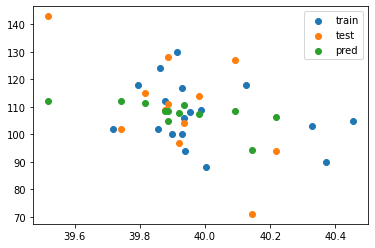

In [115]:
N = 0
dim = 1
plt.plot()
plt.scatter(tmp_train_Xy[N][0][:,dim], tmp_train_Xy[N][1],label='train')
plt.scatter(tmp_tests_x[N][:,dim], tmp_tests_y[N],label='test')
plt.scatter(tmp_tests_x[N][:,dim], tmp_preds_y[N],label='pred')
plt.legend();

## K fold GP-LLS-matern-gp-extra

In [14]:
# path = 'results/raw_gp_lls_matern_gp_extras/'
# n_ts = 24

In [15]:
# from scipy.optimize import differential_evolution
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels \
#     import ConstantKernel as C, Matern
# from sklearn.metrics import mean_squared_error
# from gp_extras.kernels import LocalLengthScalesKernel

# def de_optimizer(obj_func, initial_theta, bounds):
#     res = differential_evolution(lambda x: obj_func(x, eval_gradient=False),
#                                  bounds, maxiter=20, disp=False, polish=False)
#     return res.x, obj_func(res.x, eval_gradient=False)

In [16]:
# Check if works
# !python scripts/process_gp_lls_gp_extras.py 0 0

### Training

In [17]:
# init = time()
# jobs = []
# for fold in range(K):
#     for ts in range(n_ts):
#         jobs.append('python scripts/process_gp_lls_gp_extras.py {0} {1}'.format(ts, fold))

# print('starting',len(jobs),'jobs on',psutil.cpu_count(),'CPUs')
# sleep(1)
# n_splits = len(jobs)//64+1
# for b_id, batch in enumerate(np.array_split(jobs, n_splits)):
#     print('start',b_id+1,'of',n_splits)
#     print('length of batch=',len(batch))
#     os.system(' | '.join(batch))
#     clear_output(wait=True)
#     print('end',b_id+1,'of',n_splits)
# print((time()-init)/60, 'minutes. all fold complete')

### RMSE calculation

In [18]:
# path = 'results/raw_gp_lls_matern_gp_extras/'
# name = 'gp_extra_matern'
# master_df[name] = None
# preds = []
# tests = []
# mean_rmse_per_fold = []
# success = []
# n_fold_rmse = []
# for fold in folds:
#     hyp = []
#     fold_rmse = []
#     tmp_preds_y = []
#     tmp_models = []
#     tmp_tests_y = []
#     tmp_tests_x = []
#     tmp_train_Xy = []
#     for ts_n, ts in enumerate(df.index.unique()[:n_ts]):
#         try:
#             tmp = pd.read_pickle(path+'ts_'+str(ts)+'_fold_'+str(fold))
#             hyp.append(tmp['best_hyperpara']['N'])
#             preds.append(tmp['pred_y'].squeeze())
#             tests.append(tmp['test_y'].squeeze())
#             tmp_models.append(tmp['best_model'])
#             tmp_train_Xy.append(tmp['train_Xy'])
#             tmp_tests_x.append(tmp['test_Xy'][0].squeeze())
#             tmp_preds_y.append(tmp['pred_y'].squeeze())
#             tmp_tests_y.append(tmp['test_y'].squeeze())
#             success.append(path+'ts_'+str(ts)+'_fold_'+str(fold))
#             fold_rmse.append(mean_squared_error(tmp_tests_y[-1], tmp_preds_y[-1], squared=False))
#             master_df.loc[(str(ts_n), str(ts), str(fold)),name] = mean_squared_error(tmp_tests_y[-1], tmp_preds_y[-1], squared=False)
#         except:
#             pass
#     print('Fold',fold,'mean_rmse',np.mean(fold_rmse))
#     mean_rmse_per_fold.append(np.mean(fold_rmse))
#     print("Fold",fold,'individual_rmse',mean_squared_error(np.array(tmp_tests_y).flatten(), np.array(tmp_preds_y).flatten(), squared=False))
# print("Overall RMSE (individual)", mean_squared_error(np.array(tests).flatten(), np.array(preds).flatten(), squared=False))
# print("Overall RMSE (mean of folds)", np.mean(mean_rmse_per_fold))
# pd.Series(hyp).value_counts()

## K fold Kriging

In [19]:
path = 'results/raw_kriging/'
n_ts = 24

In [20]:
# Check if works
# !python scripts/process_kriging.py 0 0

### Training

In [21]:
# init = time()
# jobs = []
# for fold in range(K):
#     for ts in range(n_ts):
#         jobs.append('python scripts/process_kriging.py {0} {1}'.format(ts, fold))

# print('starting',len(jobs),'jobs on',psutil.cpu_count(),'CPUs')
# sleep(1)
# n_splits = len(jobs)//64+1
# for b_id, batch in enumerate(np.array_split(jobs, n_splits)):
#     print('start',b_id+1,'of',n_splits)
#     print('length of batch=',len(batch))
#     os.system(' | '.join(batch))
#     clear_output(wait=True)
#     print('end',b_id+1,'of',n_splits)
# print((time()-init)/60, 'minutes. all fold complete')

### RMSE calculation

In [22]:
path = 'results/raw_kriging/'
name = 'kriging'
master_df[name] = None
preds = []
tests = []
mean_rmse_per_fold = []
success = []
n_fold_rmse = []
for fold in folds:
    hyp = []
    fold_rmse = []
    tmp_preds_y = []
    tmp_models = []
    tmp_tests_y = []
    tmp_tests_x = []
    tmp_train_Xy = []
    for ts_n, ts in enumerate(df.index.unique()[:n_ts]):
        try:
            tmp = pd.read_pickle(path+'ts_'+str(ts)+'_fold_'+str(fold))
            hyp.append(tmp['best_hyperpara']['nlags'])
            preds.append(tmp['pred_y'].squeeze())
            tests.append(tmp['test_y'].squeeze())
            tmp_models.append(tmp['best_model'])
            tmp_train_Xy.append(tmp['train_Xy'])
            tmp_tests_x.append(tmp['test_Xy'][0].squeeze())
            tmp_preds_y.append(tmp['pred_y'].squeeze())
            tmp_tests_y.append(tmp['test_y'].squeeze())
            success.append(path+'ts_'+str(ts)+'_fold_'+str(fold))
            fold_rmse.append(mean_squared_error(tmp_tests_y[-1], tmp_preds_y[-1], squared=False))
            master_df.loc[(str(ts_n), str(ts), str(fold)),name] = mean_squared_error(tmp_tests_y[-1], tmp_preds_y[-1], squared=False)
        except:
            pass
    print('Fold',fold,'mean_rmse',np.mean(fold_rmse))
    mean_rmse_per_fold.append(np.mean(fold_rmse))
    print("Fold",fold,'individual_rmse',mean_squared_error(np.array(tmp_tests_y).flatten(), np.array(tmp_preds_y).flatten(), squared=False))
print("Overall RMSE (individual)", mean_squared_error(np.array(tests).flatten(), np.array(preds).flatten(), squared=False))
print("Overall RMSE (mean of folds)", np.mean(mean_rmse_per_fold))
pd.Series(hyp).value_counts()

Fold 0 mean_rmse 23.75316884410807
Fold 0 individual_rmse 26.699839384773693
Fold 1 mean_rmse 19.649797782390547
Fold 1 individual_rmse 22.766864313809513
Fold 2 mean_rmse 23.047641448882217
Fold 2 individual_rmse 24.967948866013174
Overall RMSE (individual) 24.863695115783937
Overall RMSE (mean of folds) 22.150202691793613


9    6
8    5
7    3
6    3
5    3
4    3
3    1
dtype: int64

## K fold GP - RBF

In [23]:
path = 'results/raw_gp_rbf/'
n_ts = 24

In [24]:
# Check if works
# !python scripts/process_gp_rbf.py 0 0

### Training

In [25]:
# init = time()
# jobs = []
# for fold in range(K):
#     for ts in range(n_ts):
#         jobs.append('python scripts/process_gp_rbf.py {0} {1}'.format(ts, fold))

# print('starting',len(jobs),'jobs on',psutil.cpu_count(),'CPUs')
# sleep(1)
# n_splits = len(jobs)//64+1
# for b_id, batch in enumerate(np.array_split(jobs, n_splits)):
#     print('start',b_id+1,'of',n_splits)
#     print('length of batch=',len(batch))
#     os.system(' | '.join(batch))
#     clear_output(wait=True)
#     print('end',b_id+1,'of',n_splits)
# print((time()-init)/60, 'minutes. all fold complete')

### RMSE calculation

In [26]:
path = 'results/raw_gp_rbf/'
name = 'stat_gp_rbf'
master_df[name] = None
preds = []
tests = []
mean_rmse_per_fold = []
success = []
n_fold_rmse = []
for fold in folds:
    hyp = []
    fold_rmse = []
    tmp_preds_y = []
    tmp_models = []
    tmp_tests_y = []
    tmp_tests_x = []
    tmp_train_Xy = []
    for ts_n, ts in enumerate(df.index.unique()[:n_ts]):
        try:
            tmp = pd.read_pickle(path+'ts_'+str(ts)+'_fold_'+str(fold))
            hyp.append(tmp['best_hyperpara']['ls_init'])
            preds.append(tmp['pred_y'].squeeze())
            tests.append(tmp['test_y'].squeeze())
            tmp_models.append(tmp['best_model'])
            tmp_train_Xy.append(tmp['train_Xy'])
            tmp_tests_x.append(tmp['test_Xy'][0].squeeze())
            tmp_preds_y.append(tmp['pred_y'].squeeze())
            tmp_tests_y.append(tmp['test_y'].squeeze())
            success.append(path+'ts_'+str(ts)+'_fold_'+str(fold))
            fold_rmse.append(mean_squared_error(tmp_tests_y[-1], tmp_preds_y[-1], squared=False))
            master_df.loc[(str(ts_n), str(ts), str(fold)),name] = mean_squared_error(tmp_tests_y[-1], tmp_preds_y[-1], squared=False)
        except:
            pass
    print('Fold',fold,'mean_rmse',np.mean(fold_rmse))
    mean_rmse_per_fold.append(np.mean(fold_rmse))
    print("Fold",fold,'individual_rmse',mean_squared_error(np.array(tmp_tests_y).flatten(), np.array(tmp_preds_y).flatten(), squared=False))
print("Overall RMSE (individual)", mean_squared_error(np.array(tests).flatten(), np.array(preds).flatten(), squared=False))
print("Overall RMSE (mean of folds)", np.mean(mean_rmse_per_fold))
pd.Series(hyp).value_counts()

Fold 0 mean_rmse 23.76587720231541
Fold 0 individual_rmse 26.610777278549186
Fold 1 mean_rmse 18.763100664774672
Fold 1 individual_rmse 21.57029630698414
Fold 2 mean_rmse 23.061756002838482
Fold 2 individual_rmse 24.955738292569148
Overall RMSE (individual) 24.469028204833727
Overall RMSE (mean of folds) 21.863577956642853


100.0    15
1.0       4
0.1       3
10.0      2
dtype: int64

## K fold GP - Matern

In [27]:
path = 'results/raw_gp_matern/'
n_ts = 24

In [28]:
# Check if works
# !python scripts/process_gp_matern.py 0 0

### Training

In [29]:
# init = time()
# jobs = []
# for fold in range(K):
#     for ts in range(n_ts):
#         jobs.append('python scripts/process_gp_matern.py {0} {1}'.format(ts, fold))

# print('starting',len(jobs),'jobs on',psutil.cpu_count(),'CPUs')
# sleep(1)
# n_splits = len(jobs)//64+1
# for b_id, batch in enumerate(np.array_split(jobs, n_splits)):
#     print('start',b_id+1,'of',n_splits)
#     print('length of batch=',len(batch))
#     os.system(' | '.join(batch))
#     clear_output(wait=True)
#     print('end',b_id+1,'of',n_splits)
# print((time()-init)/60, 'minutes. all fold complete')

### RMSE calculation

In [30]:
path = 'results/raw_gp_matern/'
name = 'stat_gp_matern'
master_df[name] = None
preds = []
tests = []
mean_rmse_per_fold = []
success = []
n_fold_rmse = []
for fold in folds:
    hyp = []
    fold_rmse = []
    tmp_preds_y = []
    tmp_models = []
    tmp_tests_y = []
    tmp_tests_x = []
    tmp_train_Xy = []
    for ts_n, ts in enumerate(df.index.unique()[:n_ts]):
        try:
            tmp = pd.read_pickle(path+'ts_'+str(ts)+'_fold_'+str(fold))
            hyp.append(tmp['best_hyperpara']['ls_init'])
            preds.append(tmp['pred_y'].squeeze())
            tests.append(tmp['test_y'].squeeze())
            tmp_models.append(tmp['best_model'])
            tmp_train_Xy.append(tmp['train_Xy'])
            tmp_tests_x.append(tmp['test_Xy'][0].squeeze())
            tmp_preds_y.append(tmp['pred_y'].squeeze())
            tmp_tests_y.append(tmp['test_y'].squeeze())
            success.append(path+'ts_'+str(ts)+'_fold_'+str(fold))
            fold_rmse.append(mean_squared_error(tmp_tests_y[-1], tmp_preds_y[-1], squared=False))
            master_df.loc[(str(ts_n), str(ts), str(fold)),name] = mean_squared_error(tmp_tests_y[-1], tmp_preds_y[-1], squared=False)
        except:
            pass
    print('Fold',fold,'mean_rmse',np.mean(fold_rmse))
    mean_rmse_per_fold.append(np.mean(fold_rmse))
    print("Fold",fold,'individual_rmse',mean_squared_error(np.array(tmp_tests_y).flatten(), np.array(tmp_preds_y).flatten(), squared=False))
print("Overall RMSE (individual)", mean_squared_error(np.array(tests).flatten(), np.array(preds).flatten(), squared=False))
print("Overall RMSE (mean of folds)", np.mean(mean_rmse_per_fold))
pd.Series(hyp).value_counts()

Fold 0 mean_rmse 23.042371974442414
Fold 0 individual_rmse 26.20930684232478
Fold 1 mean_rmse 19.049127576989353
Fold 1 individual_rmse 21.716335880678145
Fold 2 mean_rmse 22.634774057374443
Fold 2 individual_rmse 24.555288494230574
Overall RMSE (individual) 24.2314479019342
Overall RMSE (mean of folds) 21.575424536268738


100.0    12
0.1       5
10.0      4
1.0       3
dtype: int64

## Appendix and Analysis

In [31]:
master_df_pruned = master_df.dropna(how='all')

In [38]:
pd.set_option('display.max_rows', 50)
lets_see = master_df_pruned.sort_values(['lls_matern'], ascending=False)
lets_see

lls_matern  \
15 2014-05-01 19:00:00 0    79.0784   
14 2014-05-01 18:00:00 2    69.6368   
20 2014-05-02 01:00:00 1    55.1097   
8  2014-05-01 12:00:00 2    55.0207   
16 2014-05-01 21:00:00 0    52.8115   
...                             ...   
19 2014-05-02 00:00:00 1    9.51039   
22 2014-05-02 03:00:00 2    7.47419   
                       0    6.64781   
21 2014-05-02 02:00:00 0    6.48147   
22 2014-05-02 03:00:00 1    5.65938   

                                                           lls_matern_model  \
15 2014-05-01 19:00:00 0  <NSGPy.NumPy.latent_lengthscale_model.latent_l...   
14 2014-05-01 18:00:00 2  <NSGPy.NumPy.latent_lengthscale_model.latent_l...   
20 2014-05-02 01:00:00 1  <NSGPy.NumPy.latent_lengthscale_model.latent_l...   
8  2014-05-01 12:00:00 2  <NSGPy.NumPy.latent_lengthscale_model.latent_l...   
16 2014-05-01 21:00:00 0  <NSGPy.NumPy.latent_lengthscale_model.latent_l...   
...                                                                     ...   
19 2014-05-02 00:00:00 1  <NSGPy.NumPy.latent_lengthscale_model.latent_l...   
22 2014-05-02 03:00:00 2  <NSGPy.NumPy.latent_lengthscale_model.latent_l...   
                       0  <NSGPy.NumPy.latent_lengthscale_model.latent_l...   
21 2014-05-02 02:00:00 0  <NSGPy.NumPy.latent_lengthscale_model.latent_l...   
22 2014-05-02 03:00:00 1  <NSGPy.NumPy.latent_lengthscale_model.latent_l...   

                          lls_rbf  kriging stat_gp_rbf stat_gp_matern  
15 2014-05-01 19:00:00 0  52.5627  50.4421      53.322        51.8759  
14 2014-05-01 18:00:00 2  40.7253  33.8793     29.9512        30.1241  
20 2014-05-02 01:00:00 1  54.2332  54.3333     54.3487        54.3487  
8  2014-05-01 12:00:00 2  25.6862  25.5653     25.7281        25.7433  
16 2014-05-01 21:00:00 0  51.2618   50.704      51.275        51.3797  
...                           ...      ...         ...            ...  
19 2014-05-02 00:00:00 1  9.46285  10.4595     10.4084        10.4027  
22 2014-05-02 03:00:00 2  7.35378  7.96888     7.37382        7.37944  
                       0  6.37928  6.22665     7.60941        7.69981  
21 2014-05-02 02:00:00 0    6.483  6.56755     7.61375        7.73343  
22 2014-05-02 03:00:00 1  5.69599  5.88574     5.69804        5.70548  

[72 rows x 6 columns]

In [33]:
lets_see.mean() # Mean rmse across all time-stamps

lls_matern        24.557542
lls_rbf           23.867059
kriging           22.150203
stat_gp_rbf       21.863578
stat_gp_matern    21.575425
dtype: float64

In [94]:
!python scripts/process_gp_lls_self_greedy.py 20 1 matern 24

55.24511699807987 6
test_y [28, 23, 226, 22, 25, 25, 39, 43, 32, 27, 54, 36]
pred_y [39, 43, 46, 48, 49, 51, 47, 56, 43, 17, 67, 69]
len [[-0.78058272  0.53659046]
 [-0.4282816   0.40899019]
 [-0.16433776  0.15385099]
 [-0.15154373 -0.42792404]
 [ 0.12684969 -0.03605   ]
 [ 0.41362377  0.04269449]
 [-0.15559681 -0.03593495]
 [ 0.51043892 -1.06989064]
 [ 1.03232632  3.02194656]
 [-1.78124897  3.98065513]
 [ 3.14250457  1.27326213]
 [ 1.69711824 -1.70256927]]
{'likelihood (mll)': 49.80694449158155, 'GP_variance (sigma_f)': array([1634.73135993]), 'GP_noise_level (sigma_n)': array([1248.24540793]), 'L_GP_variance (sigma_f_bar)': array([1., 1.]), 'L_GP_lengthscale (sigma_l_bar)': array([175.79478409, 410.79102452]), 'L_GP_noise_level (sigma_n_bar)': array([0.001, 0.001]), 'N_lengthscales (l_bar)': array([[ 279.24049494,  103.30970743],
       [ 313.26855629, 2005.36330794],
       [  75.92515224,   99.79624234],
       [  43.46047323,  526.90888385],
       [ 679.96476626,  349.13195387],


In [20]:
test_model = pd.read_pickle('scripts/scratch/test_model')
original_params = test_model.params
test_model.params

{'likelihood (mll)': 73.64919858151589,
 'GP_variance (sigma_f)': array([227.49335149]),
 'GP_noise_level (sigma_n)': array([1.e-05]),
 'L_GP_variance (sigma_f_bar)': array([1., 1.]),
 'L_GP_lengthscale (sigma_l_bar)': array([1.e-05, 1.e-05]),
 'L_GP_noise_level (sigma_n_bar)': array([1.e-05, 1.e-05]),
 'N_lengthscales (l_bar)': array([[110.60023466,  73.34023065],
        [  1.10231994,   0.86779805],
        [101.24590959,  77.80664803],
        [ 94.04267455,  83.51167367],
        [117.55323654,  68.71873498],
        [ 96.47044885,  81.58089975],
        [100.44575126,  78.17672216],
        [ 75.50935993, 101.81582812]])}

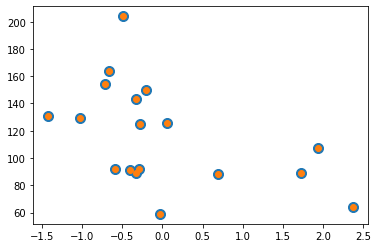

In [22]:
plt.scatter(test_model.X[:,1], test_model.y, s=100, label='train')
plt.scatter(test_model.X_star[:,1], )
plt.scatter(test_model.X[:,1], test_model.predict(test_model.X, False).squeeze(), label='train-predict')


In [8]:
test_model.l_bar[0,0] = 10
test_model.l_bar[0,1] = 1
test_model.l_bar[1,0] = 1
mean_squared_error([148, 99, 143, 67, 101, 130, 182, 82, 174, 130, 71, 103],
                   test_model.predict(test_model.X_star, False), squared=False),\
test_model.l_bar

(54.59796980129667,
 array([[ 10.        ,   1.        ],
        [  1.        ,   0.86779805],
        [101.24590959,  77.80664803],
        [ 94.04267455,  83.51167367],
        [117.55323654,  68.71873498],
        [ 96.47044885,  81.58089975],
        [100.44575126,  78.17672216],
        [ 75.50935993, 101.81582812]]))